In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import glob
from lib import dwt, ezw, size_amp, huffman, enc_dec

In [2]:
def imageEncode(image_path, quant_step):
    # Load the image
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = np.array(img)
    #2 decomposition
    l5_decomp = dwt.decomposition_to_specify_level(img, 5)
    #3 quantization
    l5_decomp_quant = np.round(l5_decomp / quant_step)
    #4 predict the lowest frequency subband
    top_16_16 = l5_decomp_quant[0:16, 0:16].flatten().astype(int)
    top_16_16_diff = np.diff(top_16_16)
    top_16_16_diff = np.insert(top_16_16_diff, 0, top_16_16[0]).tolist()
    # ezw_encode
    # enumerate the img[0,16:0,16]
    root_nodes = [[None for _ in range(16)] for _ in range(16)]
    for i in range(0, 16):
        for j in range(0, 16):
            # in order of quadrant 1,3,4
            child_1 = ezw.build_tree(l5_decomp_quant, 1, (i,j+16), 1, None)
            child_3 = ezw.build_tree(l5_decomp_quant, 1, (i+16,j), 3, None)
            child_4 = ezw.build_tree(l5_decomp_quant, 1, (i+16,j+16), 4, None)
            root_nodes[i][j] = ezw.EZWTree(l5_decomp_quant[i, j], 0, 2, (i,j), [child_1, child_3, child_4], None) # type: ignore
            child_1.parent = root_nodes[i][j] # type: ignore
            child_3.parent = root_nodes[i][j] # type: ignore
            child_4.parent = root_nodes[i][j] # type: ignore

    dpr_list= ezw.enc_dp_sp(root_nodes)
    # encode the top 16*16
    rs_16_16, ra_16_16 = size_amp.size_amplitude_single_list(top_16_16_diff)
    ra_16_16_str = ''.join(str(i) for i in ra_16_16)

    # encode the ezw tree
    result_size = []
    result_amplitude = []
    for i in range(16):
        for j in range(16):
            rs, ra = size_amp.size_amplitude_single_list(dpr_list[i][j])
            result_size = result_size + rs
            result_amplitude = result_amplitude + ra

    result_amplitude_str_lf = ''.join(str(i) for i in result_amplitude)
    # huffman encode
    huffman_dict = huffman.huffman_encode(result_size + rs_16_16)
    huffman_encoded_result_size = huffman.encode_data(result_size, huffman_dict)
    huffman_encoded_rs_16_16 = huffman.encode_data(rs_16_16, huffman_dict)

    code_table = huffman_dict

    # Convert the code table to binary
    code_table_binary = enc_dec.convert_code_table_to_binary(code_table)

    quant_step_binary = enc_dec.float_to_binary_str(float(quant_step))

    # Combine the code table and the encoded data
    # Define a separator
    separator = '11110000101001011111000010100101'

    # Combine table, quant step, encoded data
    combined_data =  code_table_binary + separator + quant_step_binary + separator + enc_dec.pad_encoded_data(huffman_encoded_result_size) + separator + enc_dec.pad_encoded_data(result_amplitude_str_lf) + separator + enc_dec.pad_encoded_data(huffman_encoded_rs_16_16) + separator + enc_dec.pad_encoded_data(ra_16_16_str)

    # Write the combined data to file
    enc_dec.write_to_binary_file(combined_data, 'encoded_data.bin')
    bpp = len(combined_data) / (512*512)
    return bpp



def imageDecode(encoded_file_path, quant_step, orginal_image_path):
    # Define a separator
    separator = '11110000101001011111000010100101'
    # Read the binary data from the file
    combined_data = enc_dec.read_from_binary_file(encoded_file_path)

    # Split the combined data into the code table and the encoded data

    code_table_binary, quant_step_binary, recon_huffman_encoded_result_size, recon_encoded_data_lf, recon_huffman_encoded_rs_16_16, recon_ra_16_16_str = enc_dec.split_data(combined_data, separator)

    # Convert the binary code table back to a dictionary
    code_table = enc_dec.convert_binary_to_code_table(code_table_binary)

    # Convert the quantization step from binary to decimal
    quant_step = enc_dec.binary_str_to_float(quant_step_binary)

    # Decode the encoded data
    recon_result_size = enc_dec.decode_data_with_huffman(recon_huffman_encoded_result_size, code_table)
    recon_result_amplitude_str_lf = enc_dec.decode_data_plain(recon_encoded_data_lf)
    recon_rs_16_16 = enc_dec.decode_data_with_huffman(recon_huffman_encoded_rs_16_16, code_table)
    recon_ra_16_16_str = enc_dec.decode_data_plain(recon_ra_16_16_str)    
    recon_dpr_list = size_amp.size_amplitude_to_2D_list_optimized(recon_result_size, recon_result_amplitude_str_lf)
    # enumerate the img[0,16:0,16]
    recon_img = np.zeros((512,512)).astype('float64')
    recon_root_nodes = [[None for _ in range(16)] for _ in range(16)]
    for i in range(0, 16):
        for j in range(0, 16):
            # in order of quadrant 1,3,4
            child_1 = ezw.build_tree(recon_img, 1, (i,j+16), 1, None)
            child_3 = ezw.build_tree(recon_img, 1, (i+16,j), 3, None)
            child_4 = ezw.build_tree(recon_img, 1, (i+16,j+16), 4, None)
            recon_root_nodes[i][j] = ezw.EZWTree(recon_img[i, j], 0, 2, (i,j), [child_1, child_3, child_4], None) # type: ignore
            child_1.parent = recon_root_nodes[i][j] # type: ignore
            child_3.parent = recon_root_nodes[i][j] # type: ignore
            child_4.parent = recon_root_nodes[i][j] # type: ignore

    recon_img = ezw.dec_dp_sp(recon_dpr_list, recon_root_nodes, recon_img)    
    # decode top 16*16
    recon_top_16_16_diff = size_amp.size_amplitude_to_2D_list(recon_rs_16_16, recon_ra_16_16_str)[0][0]

    recon_top_16_16 = np.zeros(256).astype('int')
    recon_top_16_16[0] = recon_top_16_16_diff[0]
    for i in range(1, 256):
        recon_top_16_16[i] = recon_top_16_16[i-1] + recon_top_16_16_diff[i]
    # reshape to 16*16
    recon_top_16_16 = recon_top_16_16.reshape((16,16))

    recon_img[0:16, 0:16] = recon_top_16_16
    # reverse quantization
    recon_img_after_quant = recon_img * quant_step
    # reconstruct the image
    l5_recon_img_after_quant = dwt.reconstruction_from_specify_level(recon_img_after_quant, 5)
    #PSNR
    # Load the orginal image
    img = Image.open(orginal_image_path).convert('L')  # Convert to grayscale
    img = np.array(img)
    mse = np.mean((l5_recon_img_after_quant - img) ** 2)
    psnr = 10 * np.log10(255**2 / mse)
    return psnr

In [19]:
def imageDecodeForVisualization(encoded_file_path, quant_step):
    """
    Decode image and return the reconstructed image array for visualization
    """
    # Define a separator
    separator = '11110000101001011111000010100101'
    # Read the binary data from the file
    combined_data = enc_dec.read_from_binary_file(encoded_file_path)

    # Split the combined data into the code table and the encoded data
    code_table_binary, quant_step_binary, recon_huffman_encoded_result_size, recon_encoded_data_lf, recon_huffman_encoded_rs_16_16, recon_ra_16_16_str = enc_dec.split_data(combined_data, separator)

    # Convert the binary code table back to a dictionary
    code_table = enc_dec.convert_binary_to_code_table(code_table_binary)

    # Convert the quantization step from binary to decimal
    quant_step = enc_dec.binary_str_to_float(quant_step_binary)

    # Decode the encoded data
    recon_result_size = enc_dec.decode_data_with_huffman(recon_huffman_encoded_result_size, code_table)
    recon_result_amplitude_str_lf = enc_dec.decode_data_plain(recon_encoded_data_lf)
    recon_rs_16_16 = enc_dec.decode_data_with_huffman(recon_huffman_encoded_rs_16_16, code_table)
    recon_ra_16_16_str = enc_dec.decode_data_plain(recon_ra_16_16_str)    
    recon_dpr_list = size_amp.size_amplitude_to_2D_list_optimized(recon_result_size, recon_result_amplitude_str_lf)
    
    # Reconstruct image
    recon_img = np.zeros((512,512)).astype('float64')
    recon_root_nodes = [[None for _ in range(16)] for _ in range(16)]
    for i in range(0, 16):
        for j in range(0, 16):
            child_1 = ezw.build_tree(recon_img, 1, (i,j+16), 1, None)
            child_3 = ezw.build_tree(recon_img, 1, (i+16,j), 3, None)
            child_4 = ezw.build_tree(recon_img, 1, (i+16,j+16), 4, None)
            recon_root_nodes[i][j] = ezw.EZWTree(recon_img[i, j], 0, 2, (i,j), [child_1, child_3, child_4], None)
            child_1.parent = recon_root_nodes[i][j]
            child_3.parent = recon_root_nodes[i][j]
            child_4.parent = recon_root_nodes[i][j]

    recon_img = ezw.dec_dp_sp(recon_dpr_list, recon_root_nodes, recon_img)    
    
    # Decode top 16*16
    recon_top_16_16_diff = size_amp.size_amplitude_to_2D_list(recon_rs_16_16, recon_ra_16_16_str)[0][0]
    recon_top_16_16 = np.zeros(256).astype('int')
    recon_top_16_16[0] = recon_top_16_16_diff[0]
    for i in range(1, 256):
        recon_top_16_16[i] = recon_top_16_16[i-1] + recon_top_16_16_diff[i]
    recon_top_16_16 = recon_top_16_16.reshape((16,16))

    recon_img[0:16, 0:16] = recon_top_16_16
    recon_img_after_quant = recon_img * quant_step
    l5_recon_img_after_quant = dwt.reconstruction_from_specify_level(recon_img_after_quant, 5)
    
    # Clip values to valid range
    l5_recon_img_after_quant = np.clip(l5_recon_img_after_quant, 0, 255)
    
    return l5_recon_img_after_quant.astype(np.uint8)

Found 5 images: ['IMG_1.JPG', 'IMG_2.JPG', 'IMG_3.JPG', 'IMG_4.JPG', 'lena.png']

Processing image 1/5: IMG_1.JPG
  Processing quantization step 1...
  Processing quantization step 5...
  Processing quantization step 10...
  Processing quantization step 100...

Processing image 2/5: IMG_2.JPG
  Processing quantization step 1...
  Processing quantization step 5...
  Processing quantization step 10...
  Processing quantization step 100...

Processing image 3/5: IMG_3.JPG
  Processing quantization step 1...
  Processing quantization step 5...
  Processing quantization step 10...
  Processing quantization step 100...

Processing image 4/5: IMG_4.JPG
  Processing quantization step 1...
  Processing quantization step 5...
  Processing quantization step 10...
  Processing quantization step 100...

Processing image 5/5: lena.png
  Processing quantization step 1...
  Processing quantization step 5...
  Processing quantization step 10...
  Processing quantization step 100...


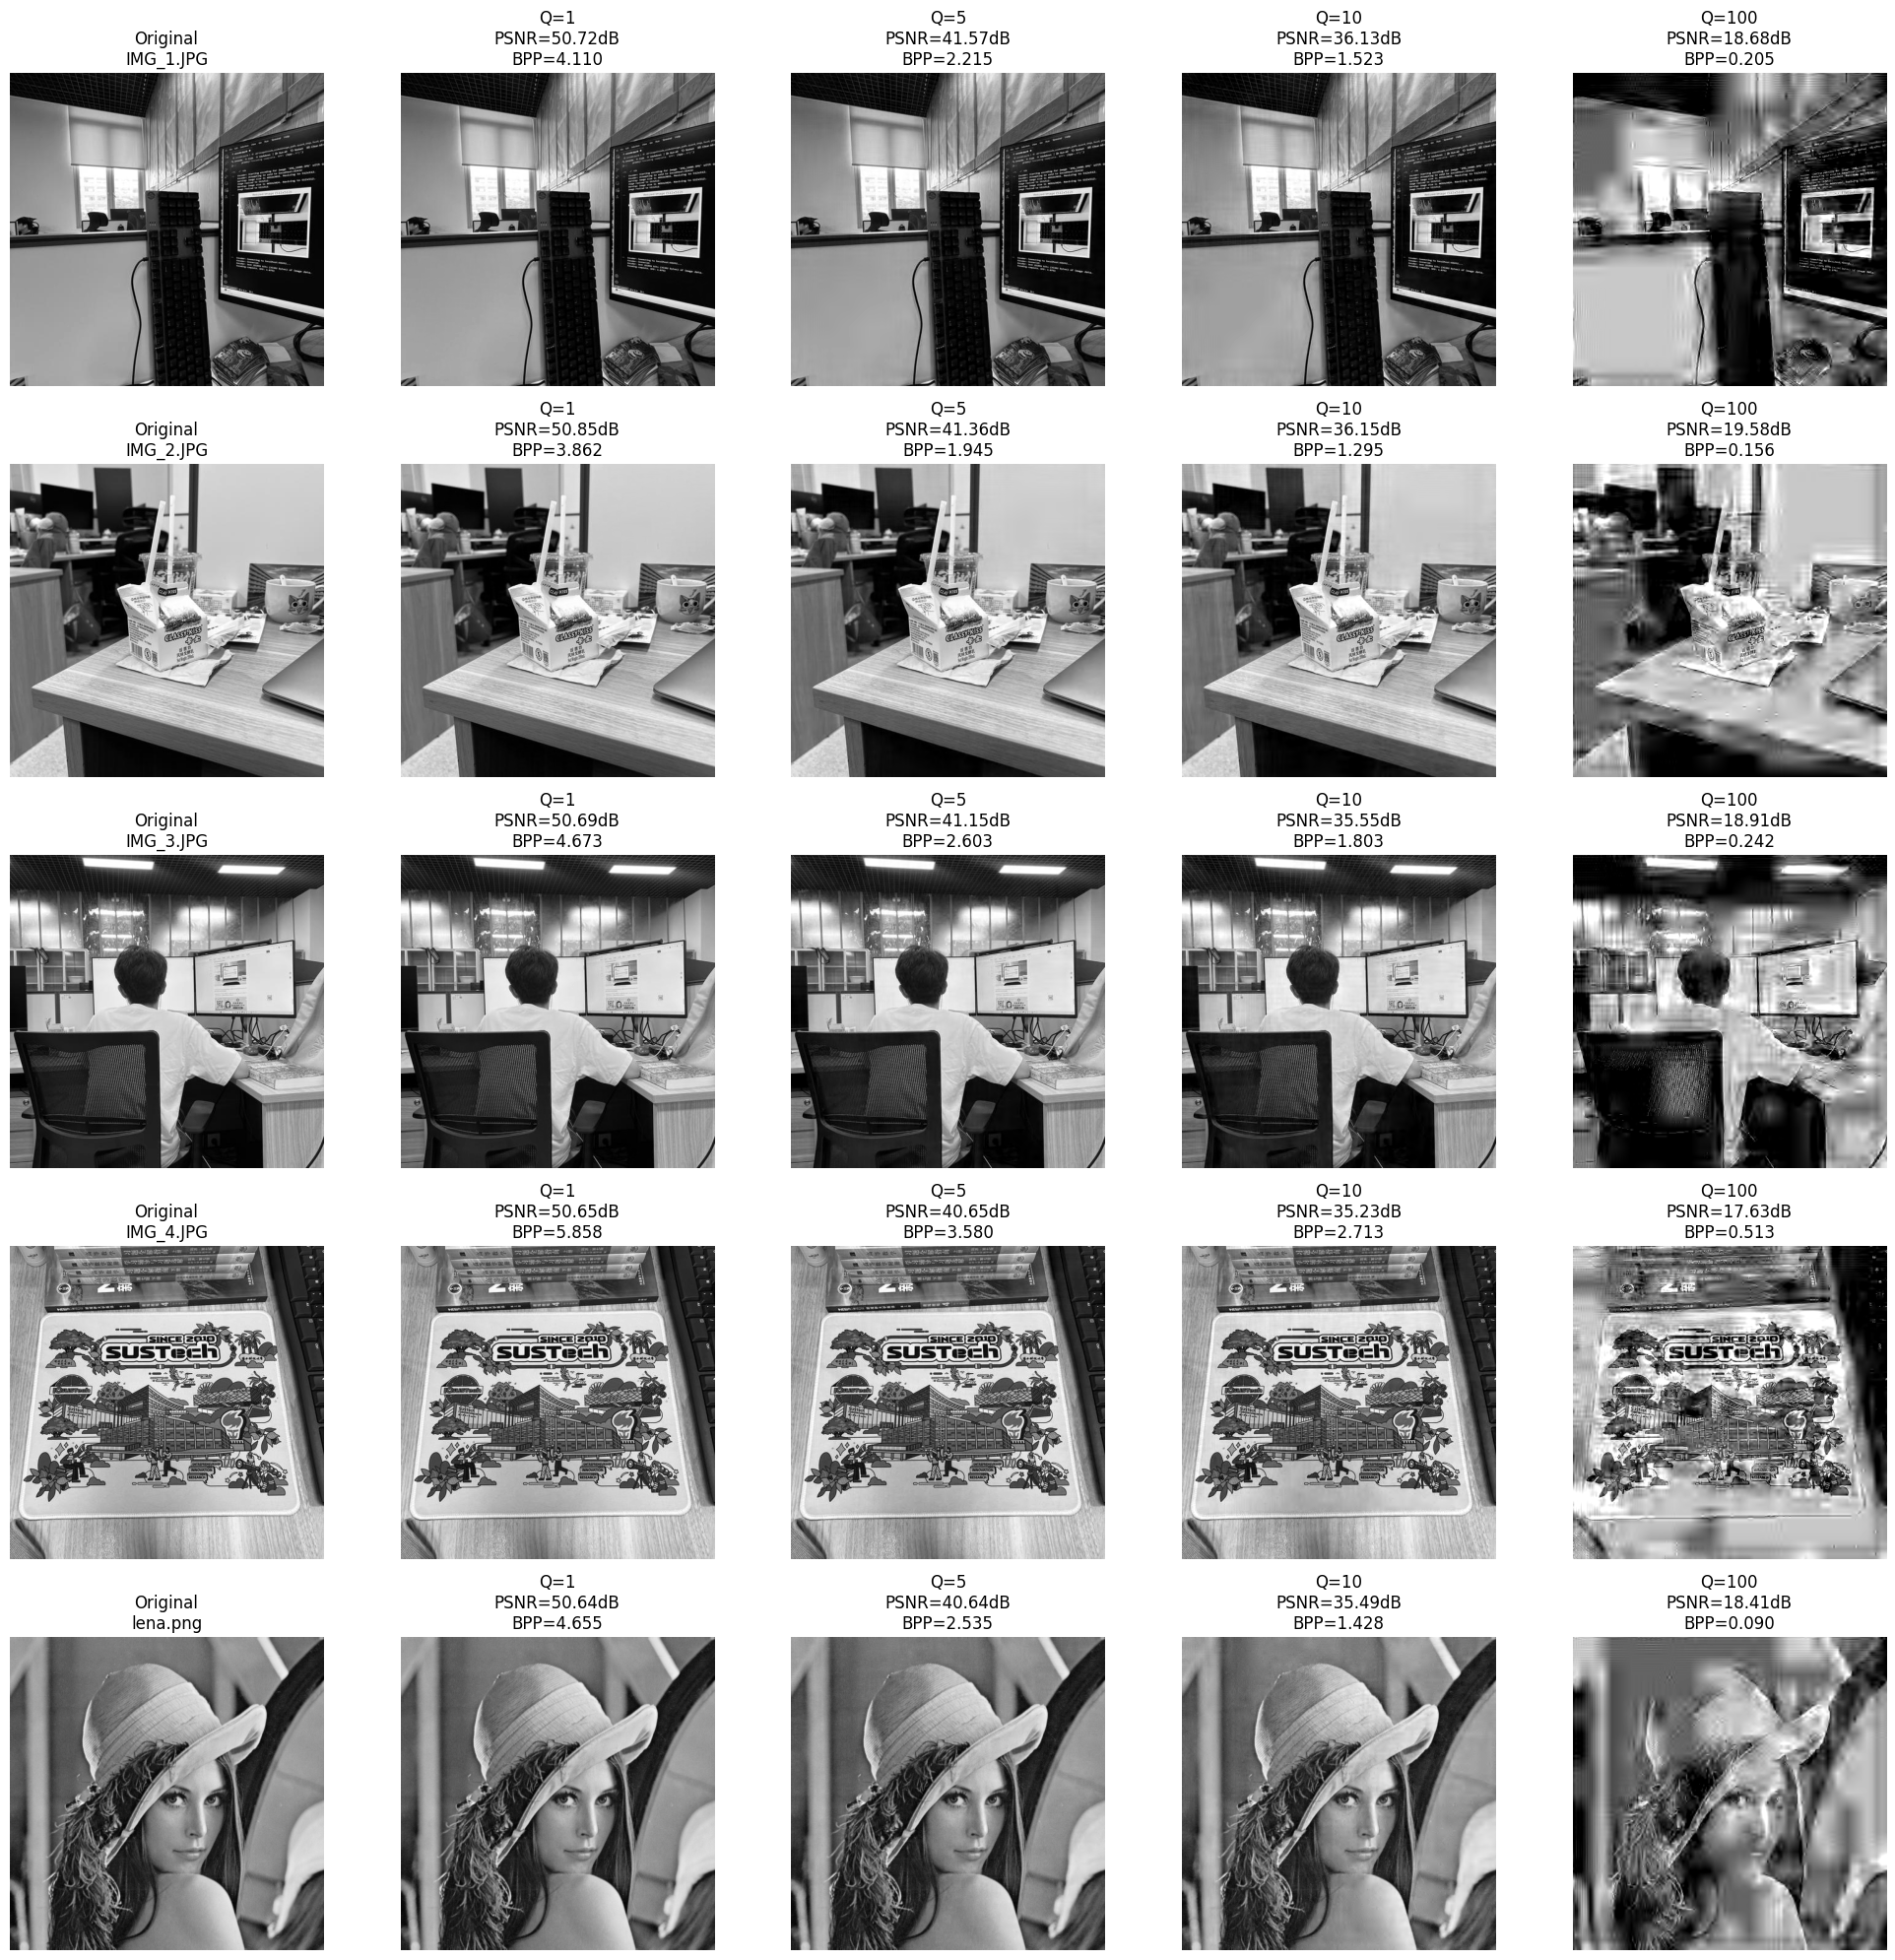


Visualization complete!


In [20]:
def create_comparison_visualization():
    """
    Create a comparison visualization showing original images and reconstructed versions
    at different quantization steps for all images in the pic folder
    """
    # Get all image files in pic folder
    pic_folder = '/home/star-koucr/Code/hw/final_project/pic'
    image_files = glob.glob(os.path.join(pic_folder, '*.png')) + glob.glob(os.path.join(pic_folder, '*.JPG')) + glob.glob(os.path.join(pic_folder, '*.jpeg'))
    image_files.sort()  # Sort for consistent ordering
    
    if len(image_files) == 0:
        print("No images found in pic folder!")
        return
    
    print(f"Found {len(image_files)} images: {[os.path.basename(f) for f in image_files]}")
    
    # Limit to 5 images as mentioned
    image_files = image_files[:5]
    
    quantization_steps = [1, 5, 10, 100]
    
    # Create figure with subplots
    fig, axes = plt.subplots(len(image_files), 5, figsize=(20, 4*len(image_files)))
    
    # Ensure axes is always 2D array
    if len(image_files) == 1:
        axes = axes.reshape(1, -1)
    elif len(image_files) > 1 and axes.ndim == 1:
        axes = axes.reshape(-1, 1)
    
    for i, image_path in enumerate(image_files):
        print(f"\nProcessing image {i+1}/{len(image_files)}: {os.path.basename(image_path)}")
        
        # Load original image
        original_img = Image.open(image_path).convert('L')
        original_img = np.array(original_img)
        
        # Get image name
        img_name = os.path.basename(image_path)
        
        # Show original image
        if len(image_files) == 1:
            current_axes = axes[0]
        else:
            current_axes = axes[i]
            
        current_axes[0].imshow(original_img, cmap='gray')
        current_axes[0].set_title(f'Original\n{img_name}')
        current_axes[0].axis('off')
        
        # Process each quantization step
        for j, quant_step in enumerate(quantization_steps):
            print(f"  Processing quantization step {quant_step}...")
            
            # Encode the image
            bpp = imageEncode(image_path, quant_step)
            
            # Decode the image for visualization
            reconstructed_img = imageDecodeForVisualization('encoded_data.bin', quant_step)
            
            # Calculate PSNR for display
            mse = np.mean((reconstructed_img.astype(float) - original_img.astype(float)) ** 2)
            psnr = 10 * np.log10(255**2 / mse) if mse > 0 else float('inf')
            
            # Show reconstructed image
            current_axes[j+1].imshow(reconstructed_img, cmap='gray')
            current_axes[j+1].set_title(f'Q={quant_step}\nPSNR={psnr:.2f}dB\nBPP={bpp:.3f}')
            current_axes[j+1].axis('off')
    
    plt.tight_layout()
    plt.show()
    print("\nVisualization complete!")

# Run the comparison
create_comparison_visualization()

In [21]:
print(imageEncode('/home/star-koucr/Code/hw/lena.png', 10))
print(imageDecode('encoded_data.bin', 10, '/home/star-koucr/Code/hw/lena.png'))

1.42816162109375
35.620301390140924


Found 5 images: ['IMG_1.JPG', 'IMG_2.JPG', 'IMG_3.JPG', 'IMG_4.JPG', 'lena.png']
Generating R-D curves for all images...

Processing image 1/5: IMG_1.JPG
  Quantization step: 1
  Quantization step: 2
  Quantization step: 2
  Quantization step: 4
  Quantization step: 4
  Quantization step: 8
  Quantization step: 8
  Quantization step: 16
  Quantization step: 16
  Quantization step: 32
  Quantization step: 32
  Quantization step: 64
  Quantization step: 64
  Quantization step: 128
  Quantization step: 128

Processing image 2/5: IMG_2.JPG
  Quantization step: 1

Processing image 2/5: IMG_2.JPG
  Quantization step: 1
  Quantization step: 2
  Quantization step: 2
  Quantization step: 4
  Quantization step: 4
  Quantization step: 8
  Quantization step: 8
  Quantization step: 16
  Quantization step: 16
  Quantization step: 32
  Quantization step: 32
  Quantization step: 64
  Quantization step: 64
  Quantization step: 128
  Quantization step: 128

Processing image 3/5: IMG_3.JPG
  Quantization

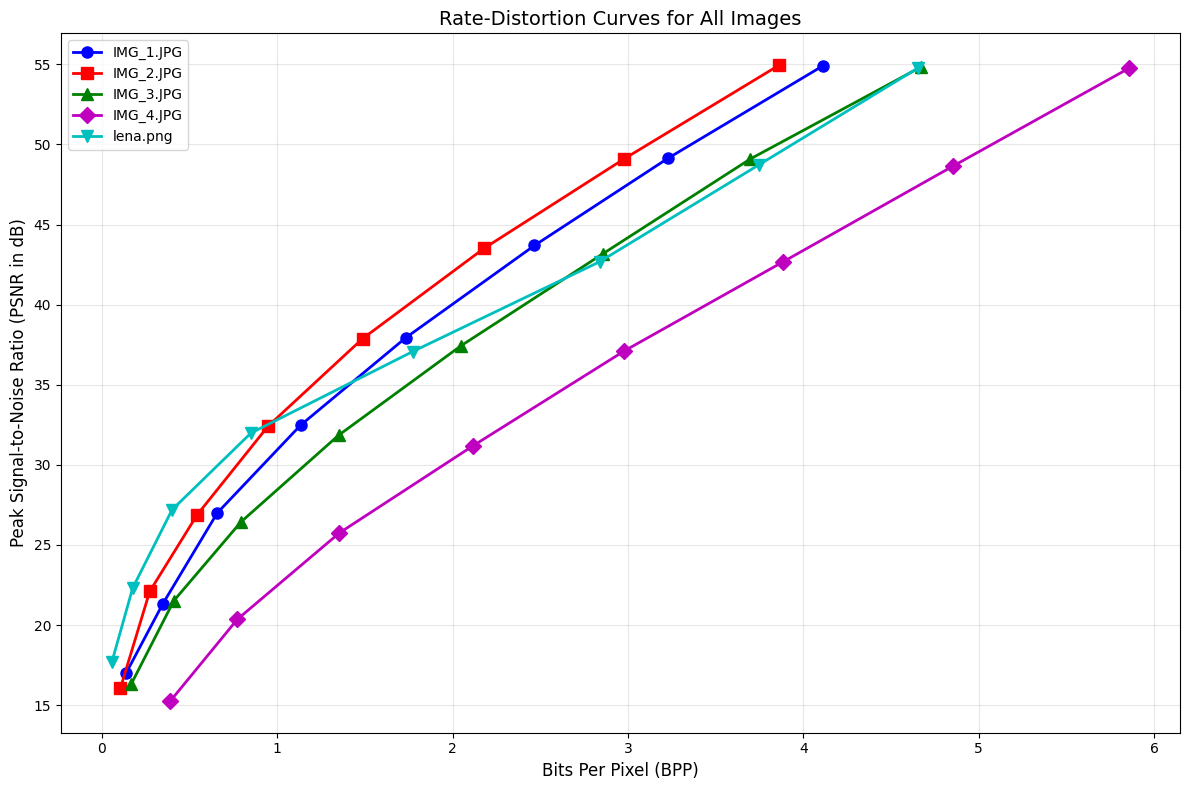


Finished generating R-D curves for all images.


In [3]:
# Get all image files in pic folder
pic_folder = '/home/star-koucr/Code/hw/final_project/pic'
image_files = glob.glob(os.path.join(pic_folder, '*.png')) + glob.glob(os.path.join(pic_folder, '*.JPG')) + glob.glob(os.path.join(pic_folder, '*.jpeg'))
image_files.sort()  # Sort for consistent ordering
image_files = image_files[:5]  # Limit to 5 images

if len(image_files) == 0:
    print("No images found in pic folder!")
else:
    print(f"Found {len(image_files)} images: {[os.path.basename(f) for f in image_files]}")
    
    quantization_steps = np.array([1, 2, 4, 8, 16, 32, 64, 128])
    
    plt.figure(figsize=(12, 8))
    colors = ['b', 'r', 'g', 'm', 'c']  # Different colors for each curve
    markers = ['o', 's', '^', 'D', 'v']  # Different markers for each curve
    
    print("Generating R-D curves for all images...")
    
    for img_idx, image_path in enumerate(image_files):
        img_name = os.path.basename(image_path)
        print(f"\nProcessing image {img_idx+1}/{len(image_files)}: {img_name}")
        
        bpp_values = []
        psnr_values = []
        
        # Generate R-D data points for current image
        for quant_step in quantization_steps:
            print(f"  Quantization step: {quant_step}")
            bpp = imageEncode(image_path, quant_step)
            psnr = imageDecode('encoded_data.bin', quant_step, image_path)
            bpp_values.append(bpp)
            psnr_values.append(psnr)
        
        # Plot curve for current image
        plt.plot(bpp_values, psnr_values, 
                marker=markers[img_idx % len(markers)], 
                color=colors[img_idx % len(colors)],
                linestyle='-', 
                linewidth=2,
                markersize=8,
                label=img_name)
    
    plt.xlabel('Bits Per Pixel (BPP)', fontsize=12)
    plt.ylabel('Peak Signal-to-Noise Ratio (PSNR in dB)', fontsize=12)
    plt.title('Rate-Distortion Curves for All Images', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()
    
    print("\nFinished generating R-D curves for all images.")